<a href="https://colab.research.google.com/github/eikegermann/audio_classifier_test/blob/main/Prototyping_network_3_class_firearm_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load libraries

In [12]:
import os
import copy
import math
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import IPython.display as ipd
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from IPython.display import Audio, display
from torchsummary import summary

# Define base functions to load dataset
Here we establish functions to process the data to be used with the model.
The functions are set up to be also usable on individual data samples so the processing for the training data sets and test samples is identical.

In [13]:
def load_audio_file(file_path, sr, duration):
    audio, _ = librosa.load(file_path, sr=sr, duration=duration, res_type='kaiser_fast')
    if len(audio) < sr * duration:
        audio = np.pad(audio, (0, sr * duration - len(audio)), mode='constant')
    return audio


def load_audio_files(data_folder, sr, duration):
    class_folders = [subfolder for subfolder in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, subfolder))]
    data = []
    labels = []

    for class_label, class_folder in enumerate(class_folders):
        class_path = os.path.join(data_folder, class_folder)
        audio_files = [file for file in os.listdir(class_path) if file.endswith('.wav')]
        for audio_file in audio_files:
            file_path = os.path.join(class_path, audio_file)
            audio = load_audio_file(file_path, sr, duration)
            data.append(audio)
            labels.append(class_label)

    return data, labels


def pad_or_truncate(tensor, fixed_length):
    if tensor.size(-1) < fixed_length:
        return torch.nn.functional.pad(tensor, (0, fixed_length - tensor.size(-1)))
    else:
        return tensor[..., :fixed_length]


def generate_mel_spectrogram(audio, sr, n_fft, n_mels, fixed_length):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, n_mels=n_mels)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec = torch.FloatTensor(mel_spec).unsqueeze(0)
    mel_spec = pad_or_truncate(mel_spec, fixed_length)
    return mel_spec


def generate_mel_spectrograms(data, sr, n_fft, n_mels, fixed_length):
    mel_spectrograms = []
    for audio in data:
        mel_spec = generate_mel_spectrogram(audio, sr, n_fft, n_mels, fixed_length)
        mel_spectrograms.append(mel_spec)
    return torch.stack(mel_spectrograms)


# Define model architecture
Here, the model architecture is defined. For the case at hand, we are using a small convolutional neural network with a few fully connected layers at the end.

In [14]:
class AudioClassifier(nn.Module):
    def __init__(self, n_mels=96, n_frames=97, n_features=3):
        super(AudioClassifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.4)

        self.fc1 = None
        self.fc2 = nn.Linear(2560, 1280)
        self.fc2a = nn.Linear(1280, 768)
        self.fc2b = nn.Linear(768, 512)
        self.fc2c = nn.Linear(512, 256)
        self.fc2d = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, n_features)
        
        self._initialize_fc1(n_mels, n_frames)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = self.dropout(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2a(x))
        x = self.dropout(x)
        x = F.relu(self.fc2b(x))
        x = F.relu(self.fc2c(x))
        x = F.relu(self.fc2d(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x
    
    def _initialize_fc1(self, n_mels, n_frames):

        with torch.no_grad():
            sample_input = torch.randn(1, 1, n_mels, n_frames)
            # print("Training Sample Input Shape:", sample_input.shape)
            x = self.pool(F.relu(self.bn1(self.conv1(sample_input))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            # print("Training X Shape:", x.shape)
            flattened_size = x.view(x.size(0), -1).shape[1]
            # print(flattened_size)
            self.fc1 = nn.Linear(flattened_size, 2560)

# Create Prototype network

The network consists of a function that uses the neural network to extract features from the

In [16]:
# Run multiple training runs to find best checkpoint

# Parameters
num_runs = 20

sr = 44100
duration = 1
n_fft = int(4096 * 3/4)
n_mels = 96
n_samples = sr * duration
hop_length = n_fft // 4
n_frames = librosa.time_to_frames(duration,
                                  sr=sr,
                                  hop_length=hop_length,
                                  n_fft=n_fft)

# Set up training parameters
num_episodes = 200
num_selected_classes_train = 3
display_interval = 25
n_features = 8
learning_rate = 3e-4
weight_decay = 0.0005
support_ratio_train = 0.6

# Set up evaluation parameters
num_eval_episodes = 100
num_selected_classes_eval = 3
support_ratio_eval = 0.6

# Training data
data_folder = 'drive/MyDrive/audio_ml_data/firearm_samples/train/'

# Load audio files and labels
audio_data, audio_labels = load_audio_files(data_folder, sr, duration)

# Generate mel-spectrograms
data = generate_mel_spectrograms(audio_data, sr, n_fft, n_mels, n_frames)
labels = torch.tensor(audio_labels)

# Test data
eval_data_dir = 'drive/MyDrive/audio_ml_data/firearm_samples/test/'

# Load eval audio files and labels
eval_data, eval_labels = load_audio_files(eval_data_dir, sr, duration)

# Generate mel-spectrograms
eval_data = generate_mel_spectrograms(eval_data, sr, n_fft, n_mels, n_frames)
eval_labels_tensor = torch.tensor(eval_labels)

# Set variable to compare evaluation accuracies
best_accuracy = 0.0

# Create a directory to save the best checkpoint
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for model_run in range(num_runs):
    print(f"Model run: {model_run}")
    #### Training Phase
    # Instantiate the embedding model
    embedding_model = AudioClassifier(n_mels=n_mels,
                                      n_frames=n_frames,
                                      n_features=n_features)

    # Set up the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(embedding_model.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay)
    
    # Create the CosineAnnealingLR scheduler
    T_max = 35  # You can choose an appropriate value for T_max
    eta_min = 1e-6  # You can choose an appropriate value for eta_min
    scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)



    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    embedding_model = embedding_model.to(device)

    # Set up interval display for high numbers of episodes
    total_loss = 0
    total_accuracy = 0
    all_true_labels = []
    all_predictions = []

    # Training loop
    for episode in range(num_episodes):
        # Randomly select a subset of classes
        available_classes = torch.unique(labels)
        selected_classes = available_classes[torch.randperm(len(available_classes))[:num_selected_classes_train]]
        selected_classes = selected_classes.to(device)

        # Initialize support and query sets
        support_set = torch.empty((0, 1, n_mels, n_frames))
        support_labels = torch.empty(0, dtype=torch.long)
        query_set = torch.empty((0, 1, n_mels, n_frames))
        query_labels = torch.empty(0, dtype=torch.long)

        # Split the data into support and query sets
        n_classes = len(set(audio_labels))

        for class_label in selected_classes:
            class_indices = [i for i, label in enumerate(audio_labels) if label == class_label]
            random.shuffle(class_indices)
            n_support = int(support_ratio_train * len(class_indices))
            support_indices = class_indices[:n_support]
            query_indices = class_indices[n_support:]

            support_set = torch.cat((support_set, data[support_indices]), dim=0)
            support_labels = torch.cat((support_labels, labels[support_indices]), dim=0)
            query_set = torch.cat((query_set, data[query_indices]), dim=0)
            query_labels = torch.cat((query_labels, labels[query_indices]), dim=0)

        # Move data to available device
        support_set = support_set.to(device)
        support_labels = support_labels.to(device)
        query_set = query_set.to(device)
        query_labels = query_labels.to(device)


        # Calculate embeddings for support and query sets
        support_embeddings = embedding_model(support_set)
        query_embeddings = embedding_model(query_set)

        # Calculate class prototypes (mean embeddings)
        class_prototypes = []
        for class_label in selected_classes:
            class_indices = (support_labels == class_label).nonzero(as_tuple=True)[0]
            class_embeddings = support_embeddings[class_indices]
            class_prototype = class_embeddings.mean(dim=0)
            class_prototypes.append(class_prototype)
        class_prototypes = torch.stack(class_prototypes)

        # Calculate the distance between query samples and class prototypes
        distances = torch.cdist(query_embeddings, class_prototypes)

        # Predict the class label based on the smallest distance
        class_probabilities = torch.softmax(-distances, dim=1)

        # Remap query labels to the new range
        query_labels_remap = torch.tensor([torch.where(selected_classes == label)[0].item() for label in query_labels], device=device)

        # Calculate the loss and optimize the model
        loss = criterion(class_probabilities, query_labels_remap)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Calculate accuracy and loss for the current episode
        predictions = torch.argmax(class_probabilities, dim=1)
        accuracy = (predictions == query_labels_remap).float().mean().item()
        total_loss += loss.item()
        total_accuracy += accuracy

        all_true_labels.extend(query_labels_remap.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

        if (episode + 1) % display_interval == 0:
            avg_loss = total_loss / display_interval
            avg_accuracy = total_accuracy / display_interval
            f1 = f1_score(all_true_labels, all_predictions, average='weighted')
            
            print(f"Episode {episode + 1}/{num_episodes}, Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}, F1 Score: {f1:.4f}")

            total_loss = 0
            total_accuracy = 0
            all_true_labels.clear()
            all_predictions.clear()

    #### Evaluation phase
    embedding_model.eval()  # Set the model to evaluation mode

    # Set up evaluation accuracy display
    eval_total_accuracy = 0
    eval_total_loss = 0
    all_eval_true_labels = []
    all_eval_predictions = []

    # Evaluation loop
    for episode in range(num_eval_episodes):
        # Randomly select a subset of classes
        available_classes = torch.unique(eval_labels_tensor)
        selected_classes = available_classes[torch.randperm(len(available_classes))[:num_selected_classes_eval]]
        selected_classes = selected_classes.to(device)

        # Initialize support and query sets
        eval_support_set = torch.empty((0, 1, n_mels, n_frames))
        eval_support_labels = torch.empty(0, dtype=torch.long)
        eval_query_set = torch.empty((0, 1, n_mels, n_frames))
        eval_query_labels = torch.empty(0, dtype=torch.long)

        # Split the data into support and query sets
        for class_label in selected_classes:
            class_indices = [i for i, label in enumerate(eval_labels) if label == class_label]
            random.shuffle(class_indices)
            n_support = int(support_ratio_eval * len(class_indices))
            support_indices = class_indices[:n_support]
            query_indices = class_indices[n_support:]

            eval_support_set = torch.cat((eval_support_set, eval_data[support_indices]), dim=0)
            eval_support_labels = torch.cat((eval_support_labels, eval_labels_tensor[support_indices]), dim=0)
            eval_query_set = torch.cat((eval_query_set, eval_data[query_indices]), dim=0)
            eval_query_labels = torch.cat((eval_query_labels, eval_labels_tensor[query_indices]), dim=0)

        # Move data to available device
        eval_support_set = eval_support_set.to(device)
        eval_support_labels = eval_support_labels.to(device)
        eval_query_set = eval_query_set.to(device)
        eval_query_labels = eval_query_labels.to(device)

        # Calculate embeddings for support and query sets
        eval_support_embeddings = embedding_model(eval_support_set)
        eval_query_embeddings = embedding_model(eval_query_set)

        # Calculate class prototypes (mean embeddings)
        class_prototypes = []
        for class_label in selected_classes:
            class_indices = (eval_support_labels == class_label).nonzero(as_tuple=True)[0]
            class_embeddings = eval_support_embeddings[class_indices]
            class_prototype = class_embeddings.mean(dim=0)
            class_prototypes.append(class_prototype)
        class_prototypes = torch.stack(class_prototypes)

        # Calculate the distance between query samples and class prototypes
        distances = torch.cdist(eval_query_embeddings, class_prototypes)

        # Predict the class label based on the smallest distance
        class_probabilities = torch.softmax(-distances, dim=1)

        # Remap query labels to the new range
        eval_query_labels_remap = torch.tensor([torch.where(selected_classes == label)[0].item() for label in eval_query_labels], device=device)

        # Calculate the loss for the current episode
        loss = criterion(class_probabilities, eval_query_labels_remap)

        # Calculate accuracy for the current episode
        predictions = torch.argmax(class_probabilities, dim=1)
        accuracy = (predictions == eval_query_labels_remap).float().mean().item()
        eval_total_loss += loss.item()
        eval_total_accuracy += accuracy

        all_eval_true_labels.extend(eval_query_labels_remap.cpu().numpy())
        all_eval_predictions.extend(predictions.cpu().numpy())

    # Calculate evaluation metrics
    eval_avg_loss = eval_total_loss / num_eval_episodes
    eval_avg_accuracy = eval_total_accuracy / num_eval_episodes
    f1 = f1_score(all_eval_true_labels, all_eval_predictions, average='weighted')

    print(f"Evaluation Average Loss: {eval_avg_loss:.4f}, Average Accuracy: {eval_avg_accuracy:.4f}, F1 Score: {f1:.4f} \n")

    if eval_avg_accuracy > best_accuracy:
        print(f"Previous best accuracy: {best_accuracy:.4f} - current accuracy: {eval_avg_accuracy:.4f}")
        best_accuracy = eval_avg_accuracy
        best_model_weights = copy.deepcopy(embedding_model.state_dict())
        print("Saving new best checkpoint... \n")
        torch.save(best_model_weights, os.path.join(checkpoint_dir, 'best_checkpoint.pth'))

print(f"Evaluation complete. Saved checkpoint has accuracy of {best_accuracy:.2f}")


Model run: 0
Episode 25/200, Avg Loss: 1.0986, Avg Accuracy: 0.3171, F1 Score: 0.3151
Episode 50/200, Avg Loss: 1.0987, Avg Accuracy: 0.2971, F1 Score: 0.2963
Episode 75/200, Avg Loss: 1.0986, Avg Accuracy: 0.3457, F1 Score: 0.3439
Episode 100/200, Avg Loss: 1.0048, Avg Accuracy: 0.6371, F1 Score: 0.6382
Episode 125/200, Avg Loss: 0.6934, Avg Accuracy: 0.8886, F1 Score: 0.8882
Episode 150/200, Avg Loss: 0.5930, Avg Accuracy: 0.9600, F1 Score: 0.9600
Episode 175/200, Avg Loss: 0.7626, Avg Accuracy: 0.7886, F1 Score: 0.7885
Episode 200/200, Avg Loss: 0.7213, Avg Accuracy: 0.8257, F1 Score: 0.8257
Evaluation Average Loss: 0.6103, Average Accuracy: 0.9417, F1 Score: 0.9416 

Previous best accuracy: 0.0000 - current accuracy: 0.9417
Saving new best checkpoint... 

Model run: 1
Episode 25/200, Avg Loss: 1.0986, Avg Accuracy: 0.3200, F1 Score: 0.3200
Episode 50/200, Avg Loss: 1.0986, Avg Accuracy: 0.3000, F1 Score: 0.2980
Episode 75/200, Avg Loss: 0.9555, Avg Accuracy: 0.7029, F1 Score: 0.704

# Test the model on single data samples
Here, we visualise the individual samples tested and play the audio for demonstration.  
The training data is used as support data with the samples tested coming from the test set.

Classes: ['1911_pistol', 'AK_47_rifle', 'Springfield_1917_rifle']
Predicted class for the test sample 'test_1911_Pistol_shot_006.wav' is: 1911_pistol


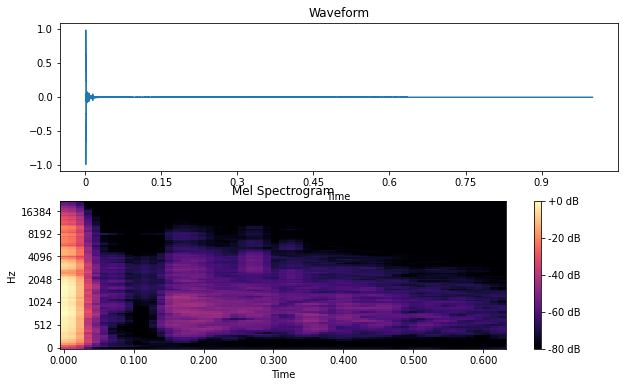

True Class Label: 1911_pistol
Predicted Class Label: 1911_pistol


In [29]:
def load_single_sample(file_path, sr, duration, n_fft, n_mels, n_frames):
    audio = load_audio_file(file_path, sr, duration)
    mel_spectrogram = generate_mel_spectrogram(audio, sr, n_fft, n_mels, n_frames)
    return audio, mel_spectrogram

def visualize_prediction(audio, S, true_class, predicted_class):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    # Plot the waveform
    ax[0].set_title("Waveform")
    librosa.display.waveshow(audio, sr=sr, ax=ax[0])

    # Plot the spectrogram
    img = librosa.display.specshow(S.squeeze().numpy(), x_axis='time', y_axis='mel', sr=sr, fmax=sr // 2, ax=ax[1])
    ax[1].set_title("Mel Spectrogram")
    fig.colorbar(img, ax=ax[1], format="%+2.f dB")

    plt.show()

    print("True Class Label:", true_class)
    print("Predicted Class Label:", predicted_class)

def play_audio(audio):
    ipd.display(ipd.Audio(audio, rate=sr))

test_sample_path = 'drive/MyDrive/audio_ml_data/firearm_samples/test/'

# Load test sample
test_folders = [subfolder for subfolder in os.listdir(test_sample_path) if os.path.isdir(os.path.join(test_sample_path, subfolder))]
test_sample_folder = random.choice(test_folders)
test_sample_path = os.path.join(test_sample_path, test_sample_folder)
test_samples = [file for file in os.listdir(test_sample_path) if file.endswith('.wav')]
test_sample_file = random.choice(test_samples)
test_sample_path = os.path.join(test_sample_path, test_sample_file)

audio, test_sample = load_single_sample(test_sample_path, sr, duration, n_fft, n_mels, n_frames)

# Convert the test sample into a batch of size 1
test_sample = test_sample.unsqueeze(0).to(device)

# Load the best checkpoint
embedding_model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_checkpoint.pth')))
embedding_model.eval()

# Support set data
support_data_folder = 'drive/MyDrive/audio_ml_data/firearm_samples/train/'

# Load audio files and labels
support_data, support_labels = load_audio_files(support_data_folder, sr, duration)

# Generate mel-spectrograms
support_data = generate_mel_spectrograms(support_data, sr, n_fft, n_mels, n_frames)
support_labels_tensor = torch.tensor(support_labels)

# Calculate embeddings for support and test samples
support_embeddings = embedding_model(support_data.to(device))
test_sample_embedding = embedding_model(test_sample)

# Calculate class prototypes (mean embeddings)
class_prototypes = []
available_classes = torch.unique(support_labels_tensor)
for class_label in available_classes:
    class_indices = (support_labels_tensor == class_label).nonzero(as_tuple=True)[0]
    class_embeddings = support_embeddings[class_indices]
    class_prototype = class_embeddings.mean(dim=0)
    class_prototypes.append(class_prototype)
class_prototypes = torch.stack(class_prototypes)

# Calculate the distance between the test sample and class prototypes
distances = torch.cdist(test_sample_embedding, class_prototypes)

# Predict the class label based on the smallest distance
class_probabilities = torch.softmax(-distances, dim=1)
prediction = torch.argmax(class_probabilities, dim=1)

# Move the prediction tensor to the CPU
prediction = prediction.cpu()

# Map the predicted class label back to the original class name
predicted_class = available_classes[prediction]

print(f"Classes: {test_folders}")
print(f"Predicted class for the test sample '{test_sample_file}' is: {test_folders[predicted_class.item()]}")

# Make information available for visualisation
true_class = test_sample_folder
pred_class = test_folders[predicted_class.item()]
sample = test_sample.cpu()

# Visualize the prediction
visualize_prediction(audio, sample, true_class, pred_class)

# Play the audio sample
play_audio(audio)
